In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [50]:
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [51]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

## Download RAF-DB dataset (Google Colab)

In [52]:
! wget https://github.com/MegaloPat/DNN/raw/main/DNN/aligned.zip

--2023-01-29 02:12:31--  https://github.com/MegaloPat/DNN/raw/main/DNN/aligned.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/aligned.zip [following]
--2023-01-29 02:12:32--  https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/aligned.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39152089 (37M) [application/zip]
Saving to: ‘aligned.zip.1’

aligned.zip.1       100%[===================>]  37.34M  --.-KB/s    in 0.1s    

2023-01-29 02:12:32 (334 MB/s) - ‘aligned.zip.1’ saved [39152089/39152089]



In [53]:
! wget https://github.com/MegaloPat/DNN/raw/main/DNN/landmark.zip

--2023-01-29 02:12:32--  https://github.com/MegaloPat/DNN/raw/main/DNN/landmark.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/landmark.zip [following]
--2023-01-29 02:12:33--  https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/landmark.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86475976 (82M) [application/zip]
Saving to: ‘landmark.zip.1’

landmark.zip.1      100%[===================>]  82.47M   346MB/s    in 0.2s    

2023-01-29 02:12:33 (346 MB/s) - ‘landmark.zip.1’ saved [86475976/86475976]



In [54]:
! wget https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/list_patition_label.txt

--2023-01-29 02:12:33--  https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/list_patition_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285305 (279K) [text/plain]
Saving to: ‘list_patition_label.txt.1’

list_patition_label 100%[===================>] 278.62K  --.-KB/s    in 0.006s  

2023-01-29 02:12:34 (44.2 MB/s) - ‘list_patition_label.txt.1’ saved [285305/285305]



## Download pretrained VGG_Face weights (Google Colab)

In [55]:
! wget https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth

--2023-01-29 02:12:34--  https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580015466 (553M)
Saving to: ‘vgg_face_dag.pth.1’

vgg_face_dag.pth.1  100%[===================>] 553.15M  14.3MB/s    in 42s     

2023-01-29 02:13:17 (13.3 MB/s) - ‘vgg_face_dag.pth.1’ saved [580015466/580015466]



# I - Vanilla classification with pretrained VGG

First we will try to get baseline results with VGG pretrained on VGG_Face without any changes.

## Prepare dataset

### Unzip data

In [56]:
import zipfile

with zipfile.ZipFile("aligned.zip", 'r') as zip_ref:
    zip_ref.extractall("./aligned")

In [57]:
!mkdir aligned/train
!mkdir aligned/test
!mv aligned/aligned/train_* aligned/train
!mv aligned/aligned/test_* aligned/test

mkdir: cannot create directory ‘aligned/train’: File exists
mkdir: cannot create directory ‘aligned/test’: File exists


### Prepare csv labels

In [58]:
import csv

with open("list_patition_label.txt","r") as file :
    train_csv = open("train_list_label.csv","w",newline="")
    test_csv = open("test_list_label.csv","w",newline="")

    train_writer = csv.writer(train_csv)
    train_writer.writerow(["Filename", "Label"])
    
    test_writer = csv.writer(test_csv)
    test_writer.writerow(["Filename", "Label"])
    
    
    for line in file:
        filename, label = line.strip().split(" ")
        idx = filename.index(".jpg")
        filename = filename[:idx] + "_aligned" + filename[idx:]
        label = str(int(label) - 1)
        
        if "train" in filename :
            train_writer.writerow([filename, label])
        else :
            test_writer.writerow([filename, label])


### Preprocessing transform
Preprocessing is the same as the experimental protocol of the original paper. This includes :
* Resize to 224x224
* Random rotation of -10° +10°
* Random horizontal flip

In [59]:
trans = transforms.Compose([
    transforms.Lambda(lambda x: x.float()),
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip()
])

### Create dataloaders
Validation set will be sampled with a stratified split of test set, as in the paper, with ratio 50/50.

Overall the proportions for the train/test/validation datasets are 80/10/10 %

Finally, we will use a batch size of 16 as in the paper.

In [60]:
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [61]:
train_data = CustomImageDataset("train_list_label.csv","./aligned/train", transform=trans)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in train: {len(train_loader)}")


Nb batches in train: 758


In [62]:
from sklearn.model_selection import train_test_split
test_data = CustomImageDataset("test_list_label.csv","./aligned/test", transform=trans)

test_indices, val_indices = train_test_split(list(range(len(test_data.img_labels.Label))), test_size=0.5, stratify=test_data.img_labels.Label)

val_data = torch.utils.data.Subset(test_data, val_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)


In [63]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in test: {len(test_loader)}")


Nb batches in test: 92


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [64]:
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in val: {len(val_loader)}")


Nb batches in val: 92


## VGG class

In [65]:

import torch
import torch.nn as nn


class Vgg(nn.Module):

    def __init__(self):
        super(Vgg, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)


    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg()
    if weights_path:
        state_dict = torch.load(weights_path)
        state_dict.pop("fc6.weight")
        state_dict.pop("fc6.bias")
        state_dict.pop("fc7.weight")
        state_dict.pop("fc7.bias")
        state_dict.pop("fc8.weight")
        state_dict.pop("fc8.bias")
        model.load_state_dict(state_dict, strict=False)
    return model

### Load pretrained weights on vgg_face

In [66]:
vgg = vgg_face("vgg_face_dag.pth")
vgg = vgg.to(device)

## Train

### Initial evaluation on validation dataset

In [67]:
cross_entropy = nn.CrossEntropyLoss()

def eval_model(net, loader):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for x, y in loader:
    with torch.no_grad():
      # No need to compute gradient here thus we avoid storing intermediary activations
      logits = net(x.to(device)).cpu()

    loss += cross_entropy(logits, y).item()
    preds = logits.argmax(dim=1)
    acc += (preds.numpy() == y.numpy()).sum()
    c += len(x)

  acc /= c
  loss /= len(loader)
  net.train()
  return acc, loss

In [68]:
initial_acc, initial_loss = eval_model(vgg, val_loader)
print(f"Initial accuracy/loss on val: {round(100 * initial_acc, 2)}/{round(initial_loss, 4)}")

Initial accuracy/loss on val: 12.57/3.0378


### Training

Training will be performed with adam optimizer, using a base learning rate of 5e-5 and polynomial decay on all epochs with a power of 0.5, for 75 epochs.  
We will save the best model according to the accuracy on the validation set.  
These parameters follow the experimental protocol of the paper.

In [69]:
from torch.optim.lr_scheduler import PolynomialLR


optimizer = torch.optim.Adam(vgg.parameters(), lr=0.00005)
scheduler = PolynomialLR(optimizer, total_iters=75, power=2)

nb_epochs = 75

train_accs, train_losses = [], []
val_accs, val_losses = [], []

In [70]:
from tqdm import tqdm
best_acc = 0
for epoch in range(nb_epochs):
  with tqdm(train_loader, unit="batch") as tepoch:
    start = time.time()
    running_acc, running_loss = 0., 0.
    c = 0
    for x, y in tepoch:
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()  # Clear previous gradients
      logits = vgg(x)
      loss = cross_entropy(logits, y)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights with gradients

      running_acc += (logits.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).sum()
      running_loss += loss.item()
      c += len(x)
      tepoch.set_postfix(loss=loss.item())
    
    scheduler.step()

    train_acc, train_loss = running_acc / c, running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    val_acc, val_loss = eval_model(vgg, val_loader)
    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(vgg.state_dict(),"vgg_best_param.pth")
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch + 1}/{nb_epochs}, "
        f"train acc/loss: {round(100 * train_acc, 2)}/{round(train_loss, 4)}, "
        f"val acc/loss: {round(100 * val_acc, 2)}/{round(val_loss, 4)}, "
        f"time {int(time.time() - start)}s"
    )

100%|██████████| 758/758 [03:29<00:00,  3.62batch/s, loss=1.47]


Epoch 1/75, train acc/loss: 42.12/1.5505, val acc/loss: 42.12/1.4842, time 219s


100%|██████████| 758/758 [03:32<00:00,  3.57batch/s, loss=1.68]


Epoch 2/75, train acc/loss: 42.41/1.531, val acc/loss: 41.64/1.4882, time 220s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.95]


Epoch 3/75, train acc/loss: 42.55/1.5294, val acc/loss: 41.78/1.4864, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.56]


Epoch 4/75, train acc/loss: 42.35/1.5263, val acc/loss: 42.66/1.4847, time 223s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.54]


Epoch 5/75, train acc/loss: 42.05/1.5286, val acc/loss: 42.19/1.4853, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.52]


Epoch 6/75, train acc/loss: 42.35/1.53, val acc/loss: 42.53/1.4816, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.52]


Epoch 7/75, train acc/loss: 41.89/1.5279, val acc/loss: 42.12/1.4834, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.28]


Epoch 8/75, train acc/loss: 42.09/1.5283, val acc/loss: 42.8/1.483, time 223s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.15]


Epoch 9/75, train acc/loss: 42.1/1.532, val acc/loss: 42.19/1.482, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.59]


Epoch 10/75, train acc/loss: 42.07/1.53, val acc/loss: 41.78/1.482, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.14]


Epoch 11/75, train acc/loss: 42.21/1.5316, val acc/loss: 41.3/1.4856, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.66]


Epoch 12/75, train acc/loss: 42.36/1.532, val acc/loss: 42.46/1.483, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.6]


Epoch 13/75, train acc/loss: 41.96/1.5301, val acc/loss: 42.39/1.4857, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.38]


Epoch 14/75, train acc/loss: 42.07/1.5349, val acc/loss: 42.19/1.4887, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.19]


Epoch 15/75, train acc/loss: 42.07/1.527, val acc/loss: 42.53/1.4848, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.5]


Epoch 16/75, train acc/loss: 42.21/1.5296, val acc/loss: 42.46/1.4822, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.52]


Epoch 17/75, train acc/loss: 42.6/1.5255, val acc/loss: 42.26/1.4803, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.9]


Epoch 18/75, train acc/loss: 42.15/1.5283, val acc/loss: 41.51/1.4856, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.5]


Epoch 19/75, train acc/loss: 42.21/1.5303, val acc/loss: 42.53/1.4842, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.43]


Epoch 20/75, train acc/loss: 42.4/1.5294, val acc/loss: 42.8/1.4835, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.5]


Epoch 21/75, train acc/loss: 42.05/1.5308, val acc/loss: 42.46/1.486, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.56]


Epoch 22/75, train acc/loss: 42.69/1.5231, val acc/loss: 42.53/1.4868, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.44]


Epoch 23/75, train acc/loss: 42.34/1.5272, val acc/loss: 42.12/1.4844, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.63]


Epoch 24/75, train acc/loss: 42.19/1.5256, val acc/loss: 41.78/1.4817, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.25]


Epoch 25/75, train acc/loss: 42.17/1.5262, val acc/loss: 42.39/1.4846, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.74]


Epoch 26/75, train acc/loss: 41.97/1.5308, val acc/loss: 41.92/1.4862, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.08]


Epoch 27/75, train acc/loss: 42.38/1.5305, val acc/loss: 42.19/1.4829, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=0.968]


Epoch 28/75, train acc/loss: 42.49/1.5299, val acc/loss: 41.98/1.4871, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.17]


Epoch 29/75, train acc/loss: 42.65/1.5289, val acc/loss: 42.32/1.4868, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.48]


Epoch 30/75, train acc/loss: 42.23/1.532, val acc/loss: 42.66/1.4833, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.31]


Epoch 31/75, train acc/loss: 42.11/1.5272, val acc/loss: 42.12/1.4861, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.89]


Epoch 32/75, train acc/loss: 42.32/1.5291, val acc/loss: 42.46/1.4847, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.43]


Epoch 33/75, train acc/loss: 42.41/1.525, val acc/loss: 42.12/1.4838, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.6]


Epoch 34/75, train acc/loss: 42.14/1.5266, val acc/loss: 41.98/1.4833, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.3]


Epoch 35/75, train acc/loss: 42.26/1.5277, val acc/loss: 42.32/1.4821, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.19]


Epoch 36/75, train acc/loss: 42.35/1.5288, val acc/loss: 42.05/1.4852, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.92]


Epoch 37/75, train acc/loss: 42.25/1.5284, val acc/loss: 42.32/1.483, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=2.24]


Epoch 38/75, train acc/loss: 42.29/1.5314, val acc/loss: 42.19/1.4844, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=2.4]


Epoch 39/75, train acc/loss: 42.3/1.5303, val acc/loss: 43.21/1.4815, time 223s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.56]


Epoch 40/75, train acc/loss: 42.57/1.5283, val acc/loss: 42.19/1.4865, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.83]


Epoch 41/75, train acc/loss: 42.29/1.5301, val acc/loss: 42.19/1.4795, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.63]


Epoch 42/75, train acc/loss: 42.26/1.5282, val acc/loss: 41.92/1.4834, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=2.14]


Epoch 43/75, train acc/loss: 42.13/1.5314, val acc/loss: 42.19/1.486, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.45]


Epoch 44/75, train acc/loss: 41.82/1.5282, val acc/loss: 42.19/1.4873, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.33]


Epoch 45/75, train acc/loss: 42.23/1.5316, val acc/loss: 42.46/1.4846, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.5]


Epoch 46/75, train acc/loss: 42.39/1.5258, val acc/loss: 42.53/1.4871, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=2.12]


Epoch 47/75, train acc/loss: 42.28/1.5287, val acc/loss: 42.12/1.4856, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.3]


Epoch 48/75, train acc/loss: 42.28/1.5243, val acc/loss: 42.05/1.4867, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.54]


Epoch 49/75, train acc/loss: 42.25/1.5277, val acc/loss: 41.71/1.4841, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.28]


Epoch 50/75, train acc/loss: 42.33/1.5251, val acc/loss: 42.66/1.4809, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.49]


Epoch 51/75, train acc/loss: 42.17/1.5289, val acc/loss: 41.92/1.4845, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.65]


Epoch 52/75, train acc/loss: 42.19/1.5296, val acc/loss: 42.39/1.4865, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.35]


Epoch 53/75, train acc/loss: 42.35/1.5248, val acc/loss: 42.46/1.4856, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.08]


Epoch 54/75, train acc/loss: 42.17/1.5288, val acc/loss: 42.26/1.4812, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.57]


Epoch 55/75, train acc/loss: 42.4/1.5257, val acc/loss: 42.32/1.4845, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.97]


Epoch 56/75, train acc/loss: 41.86/1.5316, val acc/loss: 42.05/1.485, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.81]


Epoch 57/75, train acc/loss: 42.36/1.5279, val acc/loss: 42.19/1.4799, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.01]


Epoch 58/75, train acc/loss: 42.4/1.5289, val acc/loss: 42.26/1.4823, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.49]


Epoch 59/75, train acc/loss: 42.45/1.5266, val acc/loss: 42.46/1.4841, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.59]


Epoch 60/75, train acc/loss: 42.25/1.5274, val acc/loss: 42.53/1.4856, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.76]


Epoch 61/75, train acc/loss: 42.26/1.5283, val acc/loss: 42.05/1.4864, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.56]


Epoch 62/75, train acc/loss: 42.4/1.526, val acc/loss: 42.66/1.4862, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.73]


Epoch 63/75, train acc/loss: 42.4/1.5266, val acc/loss: 42.26/1.4814, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.37]


Epoch 64/75, train acc/loss: 42.38/1.5281, val acc/loss: 42.73/1.4824, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.89]


Epoch 65/75, train acc/loss: 41.97/1.5291, val acc/loss: 42.73/1.4798, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.85]


Epoch 66/75, train acc/loss: 42.5/1.53, val acc/loss: 42.39/1.4808, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=2.03]


Epoch 67/75, train acc/loss: 42.13/1.5292, val acc/loss: 42.19/1.481, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.08]


Epoch 68/75, train acc/loss: 42.21/1.5289, val acc/loss: 42.32/1.4864, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.26]


Epoch 69/75, train acc/loss: 42.44/1.5299, val acc/loss: 42.39/1.4874, time 221s


100%|██████████| 758/758 [03:32<00:00,  3.56batch/s, loss=1.36]


Epoch 70/75, train acc/loss: 42.68/1.5285, val acc/loss: 42.32/1.4862, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.47]


Epoch 71/75, train acc/loss: 42.53/1.5293, val acc/loss: 42.53/1.4853, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.55batch/s, loss=1.78]


Epoch 72/75, train acc/loss: 42.38/1.5293, val acc/loss: 42.19/1.4834, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.41]


Epoch 73/75, train acc/loss: 42.26/1.5286, val acc/loss: 42.46/1.4853, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.48]


Epoch 74/75, train acc/loss: 41.88/1.5289, val acc/loss: 42.26/1.4863, time 221s


100%|██████████| 758/758 [03:33<00:00,  3.56batch/s, loss=1.48]


Epoch 75/75, train acc/loss: 42.19/1.5318, val acc/loss: 41.98/1.4834, time 221s


Text(0.5, 1.0, 'Loss')

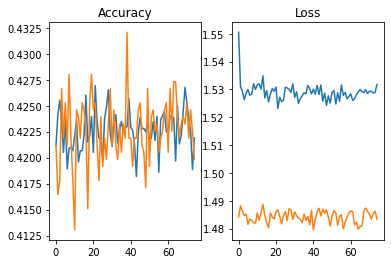

In [71]:
plt.subplot(1, 2, 1)
plt.plot(list(range(nb_epochs)), train_accs, label="Train")
plt.plot(list(range(nb_epochs)), val_accs, label="Val")
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(list(range(nb_epochs)), train_losses, label="Train")
plt.plot(list(range(nb_epochs)), val_losses, label="Val")
plt.title("Loss")

### Testing

In [72]:
state_dict = torch.load("vgg_best_param.pth")
vgg.load_state_dict(state_dict)

<All keys matched successfully>

In [73]:
test_acc, test_loss = eval_model(vgg, test_loader)
test_acc, test_loss

(0.4221617946974847, 1.4787118175755376)

# II - Vgg with Pal


Now we will train to reproduce the best results of the paper using PAL. Consequently, we will use PAL on the 15th layer, with Grad\*Input as attribution map and the half mean channel strategy. The other parameters will follow the paper, and thus will not change compared to part 1.

## Prepare dataset

### Unzip priors

In [74]:
import zipfile
with zipfile.ZipFile("landmark.zip", 'r') as zip_ref:
    zip_ref.extractall("./landmark")

In [75]:
!mkdir landmark/train
!mkdir landmark/test
!mv landmark/landmark/train_* landmark/train
!mv landmark/landmark/test_* landmark/test

mkdir: cannot create directory ‘landmark/train’: File exists
mkdir: cannot create directory ‘landmark/test’: File exists


### Create dataloaders
The process is the same as in part I, with the added priors.

In [76]:
class JoinImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, landmark_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.landmark_dir = landmark_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        land_path = os.path.join(self.landmark_dir, self.img_labels.iloc[idx, 0])
        landmark = read_image(land_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, landmark, label

In [77]:
train_data = JoinImageDataset("train_list_label.csv","./aligned/train", "./landmark/train", transform=trans)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in train: {len(train_loader)}")


Nb batches in train: 767


In [78]:
from sklearn.model_selection import train_test_split
test_data = JoinImageDataset("test_list_label.csv","./aligned/test","./landmark/test", transform=trans)

test_indices, val_indices = train_test_split(list(range(len(test_data.img_labels.Label))), test_size=0.5, stratify=test_data.img_labels.Label)

val_data = torch.utils.data.Subset(test_data, val_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

In [79]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in test: {len(test_loader)}")


Nb batches in test: 96


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [80]:
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in val: {len(val_loader)}")


Nb batches in val: 96


## Modified Vgg class
The class now outputs input and output of layer 15 in order to apply PAL.

In [81]:
import torch
import torch.nn as nn


class VggPal(Vgg):

    def __init__(self):
        super(VggPal, self).__init__()
  
    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        
        return x24,x25,x38

def vggpal_face(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = VggPal()
    if weights_path:
        state_dict = torch.load(weights_path)
        state_dict.pop("fc6.weight")
        state_dict.pop("fc6.bias")
        state_dict.pop("fc7.weight")
        state_dict.pop("fc7.bias")
        state_dict.pop("fc8.weight")
        state_dict.pop("fc8.bias")
        model.load_state_dict(state_dict, strict=False)
    return model

### Load pretrained weights on vgg_face

In [82]:
vggpal = vggpal_face("vgg_face_dag.pth")
vggpal = vggpal.to(device)

## Definition of PAL

In [83]:
def Grad(inputs, outputs) :
    outputs_sum = outputs.sum()
    inputs.retain_grad()
    outputs.retain_grad()
    outputs_sum.backward(retain_graph=True)
    return torch.abs(inputs.grad)

def GradxInput(inputs, outputs) :
    Grad_val = Grad(inputs, outputs)
    return Grad_val * inputs

def PAL(inputs, outputs, prior, attribution_method, channel_strategy=None) :
    attribution_map = attribution_method(inputs, outputs)
    
    if channel_strategy == "half_mean" :
        nb_class = attribution_map.shape[1]
        attribution_map[:, int(nb_class/2):, :, :]
    
    if channel_strategy == "half_mean" or channel_strategy == "mean" :
        attribution_map = attribution_map.mean(1).unsqueeze(1)
    
    attribution_map_resize = transforms.Resize(attribution_map.shape[-2:])
    
    prior = attribution_map_resize(prior)
    
    std = attribution_map.view(attribution_map.size(0), -1).std(1)
    mean = attribution_map.view(attribution_map.size(0), -1).mean(1)
    
    
    res = (attribution_map - mean.view(-1, 1, 1, 1)) / std.view(-1, 1, 1, 1)
    res = res * prior.unsqueeze(1)
    
    res = res.view(res.size(0), -1).sum(1)
    res = -res
    return res.mean()

In [84]:
def tot_loss(li, lo, prior, logits, y):
    pa_loss = PAL(li, lo, prior, GradxInput, "half_mean")
    ce_loss = cross_entropy(logits, y)
    return pa_loss + ce_loss

## Train

### Initial evaluation on validation dataset

In [85]:
def eval_modelpal(net, loader):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for x, prior, y in loader:
    x, prior, y = x.to(device), prior.to(device),y.to(device)
    li, lo, logits = net(x.to(device))
    loss += tot_loss(li, lo, prior, logits, y).item()
    preds = logits.argmax(dim=1)
    acc += (preds.cpu().numpy() == y.cpu().numpy()).sum()
    c += len(x)

  acc /= c
  loss /= len(loader)
  net.train()
  return acc, loss

In [86]:
initial_acc, initial_loss = eval_modelpal(vggpal, val_loader)
print(f"Initial accuracy/loss on val: {round(100 * initial_acc, 2)}/{round(initial_loss, 4)}")

Initial accuracy/loss on val: 25.36/40341.8236


### Training

In [87]:
optimizer = torch.optim.Adam(vggpal.parameters(), lr=0.00005)
scheduler = PolynomialLR(optimizer, total_iters=75, power=2)

nb_epochs = 75

train_accs, train_losses = [], []
val_accs, val_losses = [], []

In [ ]:
from tqdm import tqdm
best_acc = 0
for epoch in range(nb_epochs):
  with tqdm(train_loader, unit="batch") as tepoch:
    start = time.time()
    running_acc, running_loss = 0., 0.
    c = 0
    for x, prior, y in tepoch:
      x, prior, y = x.to(device), prior.to(device),y.to(device)

      optimizer.zero_grad()  # Clear previous gradients
      li, lo ,logits = vggpal(x)
      loss = tot_loss(li, lo, prior, logits, y)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights with gradients

      running_acc += (logits.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).sum()
      running_loss += loss.item()
      c += len(x)
      tepoch.set_postfix(loss=loss.item())

    scheduler.step()

    train_acc, train_loss = running_acc / c, running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    val_acc, val_loss = eval_modelpal(vggpal, val_loader)
    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(vggpal.state_dict(),"vggpal_best_param.pth")
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch + 1}/{nb_epochs}, "
        f"train acc/loss: {round(100 * train_acc, 2)}/{round(train_loss, 4)}, "
        f"val acc/loss: {round(100 * val_acc, 2)}/{round(val_loss, 4)}, "
        f"time {int(time.time() - start)}s"
    )

100%|██████████| 767/767 [05:13<00:00,  2.45batch/s, loss=9.31e+4]


Epoch 1/75, train acc/loss: 38.77/92826.6236, val acc/loss: 38.59/90788.7556, time 336s


100%|██████████| 767/767 [05:13<00:00,  2.45batch/s, loss=7.7e+4]


Epoch 2/75, train acc/loss: 38.91/91588.1951, val acc/loss: 38.59/91349.7791, time 334s


100%|██████████| 767/767 [05:13<00:00,  2.45batch/s, loss=8.54e+4]


Epoch 3/75, train acc/loss: 38.86/91583.1396, val acc/loss: 38.59/91956.8169, time 334s


100%|██████████| 767/767 [05:13<00:00,  2.45batch/s, loss=8.86e+4]


Epoch 4/75, train acc/loss: 38.88/91836.8825, val acc/loss: 38.59/92087.8805, time 334s


100%|██████████| 767/767 [05:13<00:00,  2.45batch/s, loss=9.28e+4]


Epoch 5/75, train acc/loss: 38.89/91725.0407, val acc/loss: 38.59/91027.6633, time 334s


100%|██████████| 767/767 [05:13<00:00,  2.45batch/s, loss=8.92e+4]


Epoch 6/75, train acc/loss: 38.86/91587.4653, val acc/loss: 38.59/91490.6176, time 334s


100%|██████████| 767/767 [05:13<00:00,  2.45batch/s, loss=8.37e+4]


Epoch 7/75, train acc/loss: 38.9/91802.0658, val acc/loss: 38.59/90996.9875, time 334s


100%|██████████| 767/767 [05:13<00:00,  2.44batch/s, loss=9.05e+4]


Epoch 8/75, train acc/loss: 38.86/91982.7924, val acc/loss: 38.59/91327.6587, time 334s


100%|██████████| 767/767 [05:13<00:00,  2.44batch/s, loss=8.87e+4]


Epoch 9/75, train acc/loss: 38.92/91768.6697, val acc/loss: 38.59/91635.3411, time 334s


100%|██████████| 767/767 [05:14<00:00,  2.44batch/s, loss=8.51e+4]


Epoch 10/75, train acc/loss: 38.9/91817.9431, val acc/loss: 38.59/91605.0011, time 334s


100%|██████████| 767/767 [05:14<00:00,  2.44batch/s, loss=1.06e+5]


Epoch 11/75, train acc/loss: 38.89/91710.9766, val acc/loss: 38.59/91369.2567, time 335s


100%|██████████| 767/767 [05:14<00:00,  2.44batch/s, loss=9.07e+4]


Epoch 12/75, train acc/loss: 38.9/91896.9998, val acc/loss: 38.59/91639.8052, time 335s


100%|██████████| 767/767 [05:14<00:00,  2.44batch/s, loss=7.81e+4]


Epoch 13/75, train acc/loss: 38.88/91562.4983, val acc/loss: 38.59/91141.4811, time 334s


100%|██████████| 767/767 [05:14<00:00,  2.44batch/s, loss=8.21e+4]


Epoch 14/75, train acc/loss: 38.91/91854.6084, val acc/loss: 38.59/91688.7273, time 335s


 24%|██▍       | 185/767 [01:15<03:57,  2.45batch/s, loss=1.01e+5]

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(list(range(nb_epochs)), train_accs, label="Train")
plt.plot(list(range(nb_epochs)), val_accs, label="Val")
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(list(range(nb_epochs)), train_losses, label="Train")
plt.plot(list(range(nb_epochs)), val_losses, label="Val")
plt.title("Loss")

### Testing

In [ ]:
state_dict = torch.load("vggpal_best_param.pth")
vgg.load_state_dict(state_dict)

In [ ]:
test_acc, test_loss = eval_modelpal(vgg, test_loader)
test_acc, test_loss